# Example Notebook for dilepton events with opposite charge, same flavor

As an example, use the ttW, ttZ and diboson samples and select events with two leptons, same flavor, opposite charge.
By selecting events with many jets and at least on b-tagged jet, one should mainly select ttZ events.
In this example, the large DY and tt+jets samples are neglected in order to reduce the processing time.

Make yourself familiar with the concept of the processor:
- What are the different kind of axes we define?
- Which kinds of objects do we define (jets, leptons...)
- How do selections of objects and events work?
- How does one take weights into account?
- How to add lines to a cutflow table
- How to plot momenta of jets, leptons etc


In [1]:
import os
import time
import glob
import re
import pandas as pd
from functools import reduce
from klepto.archives import dir_archive

import numpy as np
from tqdm.auto import tqdm
import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea.analysis_objects import JaggedCandidateArray
from coffea import hist
import pandas as pd
import uproot_methods
import awkward

from memory_profiler import profile

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from Tools.helpers import addRowToCutFlow, loadConfig, getCutFlowTable

# This just tells matplotlib not to open any
# interactive windows.
matplotlib.use('Agg')

In [2]:
class exampleProcessor(processor.ProcessorABC):
    """Dummy processor used to demonstrate the processor principle"""
    def __init__(self):

        # some definitions of different axis types
        # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset",   "Primary dataset")
        pt_axis             = hist.Bin("pt",        r"$p_{T}$ (GeV)", 1000, 0, 1000)
        ht_axis             = hist.Bin("ht",        r"$H_{T}$ (GeV)", 500, 0, 5000)
        mass_axis           = hist.Bin("mass",      r"M (GeV)", 1000, 0, 2000)
        eta_axis            = hist.Bin("eta",       r"$\eta$", 60, -5.5, 5.5)
        multiplicity_axis   = hist.Bin("multiplicity",         r"N", 20, -0.5, 19.5)
        norm_axis            = hist.Bin("norm",         r"N", 25, 0, 1)

        # define the histograms and processes here
        self._accumulator = processor.dict_accumulator({
            "MET_pt" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "N_b" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_jet" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "dilepton_mass" :   hist.Hist("Counts", dataset_axis, mass_axis),
            "dilepton_pt" :     hist.Hist("Counts", dataset_axis, pt_axis),

            'diboson':          processor.defaultdict_accumulator(int),
            'TTW':              processor.defaultdict_accumulator(int),
            'TTZ':              processor.defaultdict_accumulator(int),
            'totalEvents':      processor.defaultdict_accumulator(int),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        dataset = df["dataset"]
        cfg = loadConfig()

        # load all the default candidates (jets, leptons, ...)
        
        ## Jets
        jet = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt = df['Jet_pt'].content,
            eta = df['Jet_eta'].content,
            phi = df['Jet_phi'].content,
            mass = df['Jet_mass'].content,
            goodjet = df['Jet_isGoodJetAll'].content,
            bjet = df['Jet_isGoodBJet'].content,
            jetId = df['Jet_jetId'].content,
            puId = df['Jet_puId'].content,
        )
        # all jets with certain quality criterea (goodjet)
        jet       = jet[(jet['goodjet']==1)]
        # only b-tagged jets
        btag      = jet[jet['bjet']==1]
        # good jets that are not b-tagged are assumed to be light flavor jets (u/d/s/c quarks of gluons)
        light     = jet[(jet['goodjet']==1) & (jet['bjet']==0)]
        # for top-W scattering, or top-Z scattering, forward jets are assumed to come from a spectator quark. we don't use them below, but maybe later
        spectator = jet[(abs(jet.eta)>2.0) & (abs(jet.eta)<4.7) & (jet.pt>25) & (jet['puId']>=7) & (jet['jetId']>=6)] # 40 GeV seemed good. let's try going lower
        # select the spectator jet with the highest transverse momentum
        leading_spectator = spectator[spectator.pt.argmax()]
        
        ## Leptons
        lepton = JaggedCandidateArray.candidatesfromcounts(
            df['nLepton'],
            pt = df['Lepton_pt'].content,
            eta = df['Lepton_eta'].content,
            phi = df['Lepton_phi'].content,
            mass = df['Lepton_mass'].content,
            pdgId = df['Lepton_pdgId'].content,
        )
        dilepton = lepton.choose(2)

        ## Muons
        muon = lepton[abs(lepton['pdgId'])==13]
        dimuon = muon.choose(2)
        OSmuon = (dimuon.i0['pdgId'] * dimuon.i1['pdgId'] < 0) # select two muons with opposite charge
        dimuon = dimuon[OSmuon]

        ## Electrons
        electron = lepton[abs(lepton['pdgId'])==11]
        dielectron = electron.choose(2)
        OSelectron = (dielectron.i0['pdgId'] * dielectron.i1['pdgId'] < 0) # select two electrons with opposite charge
        dielectron = dielectron[OSelectron]

        ## MET
        met_pt  = df["MET_pt"]
        met_phi = df["MET_phi"]

        ## Event classifieres
        
        
        ## define selections (maybe move to a different file at some point)
        dilep       = ((df['nLepton']==2) & (df['nVetoLepton']>=2))
        sixJet      = (jet.counts>=6) # those are any two jets
        oneBTag     = (btag.counts>0)
        twoMuon     = ( muon.counts==2 )
        twoElectron = ( electron.counts==2 )
        onZ_mu      = ( (abs(dimuon.mass-91.)<15).counts>0 )
        onZ_ele     = ( (abs(dielectron.mass-91.)<15).counts>0 )
        met         = (met_pt > 50)
        fwdJet = (spectator.counts>0)
        fwdJet50 = ((leading_spectator.pt>50).counts>0)


        ## work on the cutflow
        output['totalEvents']['all'] += len(df['weight'])

        addRowToCutFlow( output, df, cfg, 'skim',        None, processes=['TTW', 'TTZ', 'diboson'] ) # entry point
        addRowToCutFlow( output, df, cfg, 'dilep',       dilep, processes=['TTW', 'TTZ', 'diboson'] )
        addRowToCutFlow( output, df, cfg, 'sixJet',      dilep & sixJet, processes=['TTW', 'TTZ', 'diboson'] )
        addRowToCutFlow( output, df, cfg, 'oneBTag',     dilep & sixJet & oneBTag, processes=['TTW', 'TTZ', 'diboson'] )
        addRowToCutFlow( output, df, cfg, 'SF',          dilep & sixJet & oneBTag & (twoMuon | twoElectron), processes=['TTW', 'TTZ', 'diboson'] )
        addRowToCutFlow( output, df, cfg, 'onZ',         dilep & sixJet & oneBTag & (twoMuon | twoElectron) & (onZ_mu | onZ_ele), processes=['TTW', 'TTZ', 'diboson'] )


        # preselection of events
        event_selection = dilep & sixJet & oneBTag & (twoMuon | twoElectron)
        
        ## And fill the histograms
        # N jet and N b without selections on those
        output['N_jet'].fill(dataset=dataset, multiplicity=jet[dilep].counts, weight=df['weight'][dilep]*cfg['lumi'])
        output['N_b'].fill(dataset=dataset, multiplicity=btag[dilep].counts, weight=df['weight'][dilep]*cfg['lumi'])

        output['dilepton_mass'].fill(dataset=dataset, mass=dilepton[event_selection].mass.flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['dilepton_pt'].fill(dataset=dataset, pt=dilepton[event_selection].pt.flatten(), weight=df['weight'][event_selection]*cfg['lumi'])

        return output

    def postprocess(self, accumulator):
        return accumulator


In [3]:
overwrite = False
small = True

# load the config and the cache
cfg = loadConfig()

cacheName = 'example'

from samples import fileset, fileset_2lOS

# histograms
histograms = []
histograms += ['N_b', 'N_jet', 'dilepton_mass', 'dilepton_pt']

# initialize cache
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cfg['caches'][cacheName]), serialized=True)
if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    # Run the processor
    fileset = {'TTW':fileset_2lOS['TTW'], 'TTZ':fileset_2lOS['TTZ'], 'diboson':fileset_2lOS['diboson']}
    workers = 8
    output = processor.run_uproot_job(fileset,
                                      treename='Events',
                                      processor_instance=exampleProcessor(),
                                      executor=processor.futures_executor,
                                      executor_args={'workers': workers, 'function_args': {'flatten': False}},
                                      chunksize=500000,
                                     )
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()



/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


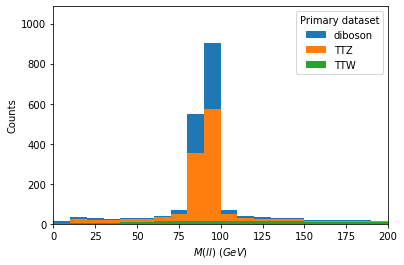

In [4]:
histogram = output['dilepton_mass']
histogram = histogram.rebin('mass', hist.Bin('mass', r'$M(ll) \ (GeV)$', 20, 0, 200))
ax = hist.plot1d(histogram,overlay="dataset", stack=True)

/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


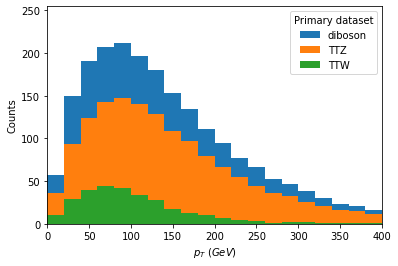

In [5]:
histogram = output['dilepton_pt']
histogram = histogram.rebin('pt', hist.Bin('pt', r'$p_{T} \ (GeV)$', 20, 0, 400))
ax = hist.plot1d(histogram,overlay="dataset", stack=True)

/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


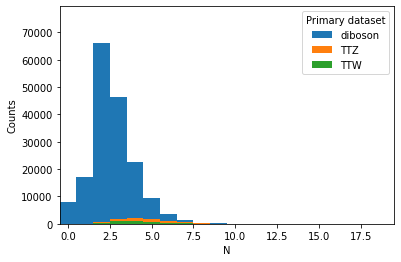

In [6]:
histogram = output['N_jet']
ax = hist.plot1d(histogram,overlay="dataset", stack=True)

/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


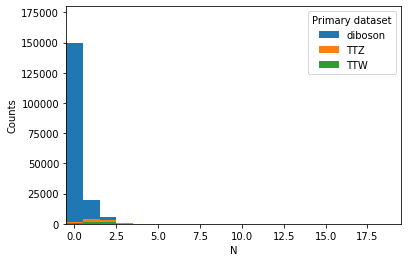

In [7]:
histogram = output['N_b']
ax = hist.plot1d(histogram,overlay="dataset", stack=True)

In [9]:
cutflow = getCutFlowTable(output, processes=['TTW', 'TTZ', 'diboson'], lines=['skim', 'dilep','sixJet','oneBTag','SF','onZ'], significantFigures=4)

                      TTW               TTZ               diboson
skim     27870.0 +/- 60.0  14820.0 +/- 10.0  1083000.0 +/- 1000.0
dilep     3954.0 +/- 17.0    4380.0 +/- 7.0    167100.0 +/- 200.0
sixJet      668.6 +/- 8.7    1491.0 +/- 5.0       3533.0 +/- 20.0
oneBTag     586.3 +/- 8.2    1303.0 +/- 5.0         719.8 +/- 8.5
SF          295.9 +/- 5.8    1179.0 +/- 4.0         672.4 +/- 7.8
onZ         198.2 +/- 5.6    1122.0 +/- 4.0         661.8 +/- 7.7


In [10]:
cutflow

,TTW,TTZ,diboson
skim,27870.0 +/- 60.0,14820.0 +/- 10.0,1083000.0 +/- 1000.0
dilep,3954.0 +/- 17.0,4380.0 +/- 7.0,167100.0 +/- 200.0
sixJet,668.6 +/- 8.7,1491.0 +/- 5.0,3533.0 +/- 20.0
oneBTag,586.3 +/- 8.2,1303.0 +/- 5.0,719.8 +/- 8.5
SF,295.9 +/- 5.8,1179.0 +/- 4.0,672.4 +/- 7.8
onZ,198.2 +/- 5.6,1122.0 +/- 4.0,661.8 +/- 7.7
